*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall23/notebooks/module06_01_decision_trees.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Decision Trees

Decision trees are a classic classifier that has been very popular because of its intuitive nature and fast training algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### The Iris data revisited

The Iris data is an excellent dataset to introduce decision trees.  We will visualize it to remind ourselves of its characteristics.

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y  = iris.target
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [3]:
def scatter_with_legend(X, y, ax, class_names) :
    colors = ['ob', 'or', 'oc']
    for c in range(len(class_names)):
        idx = (y==c)
        ax.plot(X[idx,0], X[idx,1], colors[c], 
                label = class_names[c], alpha=0.5)
    ax.legend()

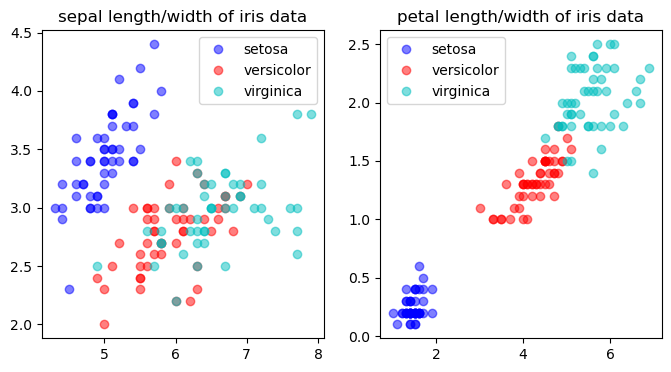

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
scatter_with_legend(X[:,[0, 1]], y, ax1, iris.target_names)
scatter_with_legend(X[:,[2, 3]], y, ax2, iris.target_names)
ax1.set_title('sepal length/width of iris data')
ax2.set_title('petal length/width of iris data');

From these plots we can see that there are simple rules based on the values of single features that can provide good accuracy.  For example, if petal length is less than 2.5, we would classify an iris as belonging to the species iris setosa.

## Decision Trees - Divide and Conquer

Decision trees capture the very intuitive way in which we as humans make decisions, as a set of rules.  As an example consider the following very simple decision tree that provides high classification accuracy between Iris versicolor and Iris virginica:

<img style="padding: 10px; float:center;" alt="created by X7q in public domain" src="https://upload.wikimedia.org/wikipedia/commons/c/cf/Decision_stump.svg" width="400">

To see this in code, let's consider the iris dataset and use the **last two** features, petal length and petal width:

In [5]:
features = [2,3]
X = iris.data[:, features]
y = iris.target
fnames = np.array([iris['feature_names'][i] for i in features])
print(f'Using features: {fnames}')

Using features: ['petal length (cm)' 'petal width (cm)']


Now, let's create a decision tree using scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) implementation of decision trees:

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree = DecisionTreeClassifier(max_depth=2,random_state=42)
tree.fit(X, y);

As it name suggests, the `max_depth` parameter controls the depth of the resulting tree. 
Next, let's plot the tree:

Training Set Accuracy is: 0.96


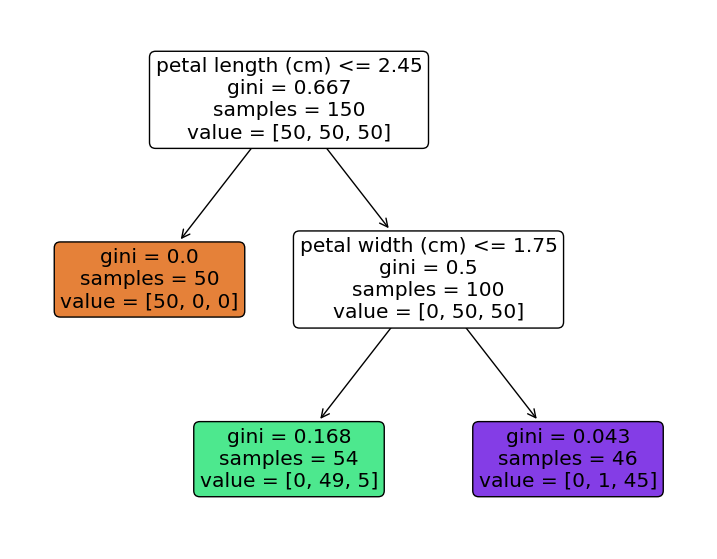

In [7]:
plt.figure(figsize=(9,7))
plot_tree(tree, filled=True, rounded=True, feature_names=fnames)
print(f'Training Set Accuracy is: {tree.score(X,y):2.2f}')

Note the functionality provided for [plotting the decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) which we just utilized.

Perhaps an even more helpful visualization follows, showing the decision boundary for the classifier:

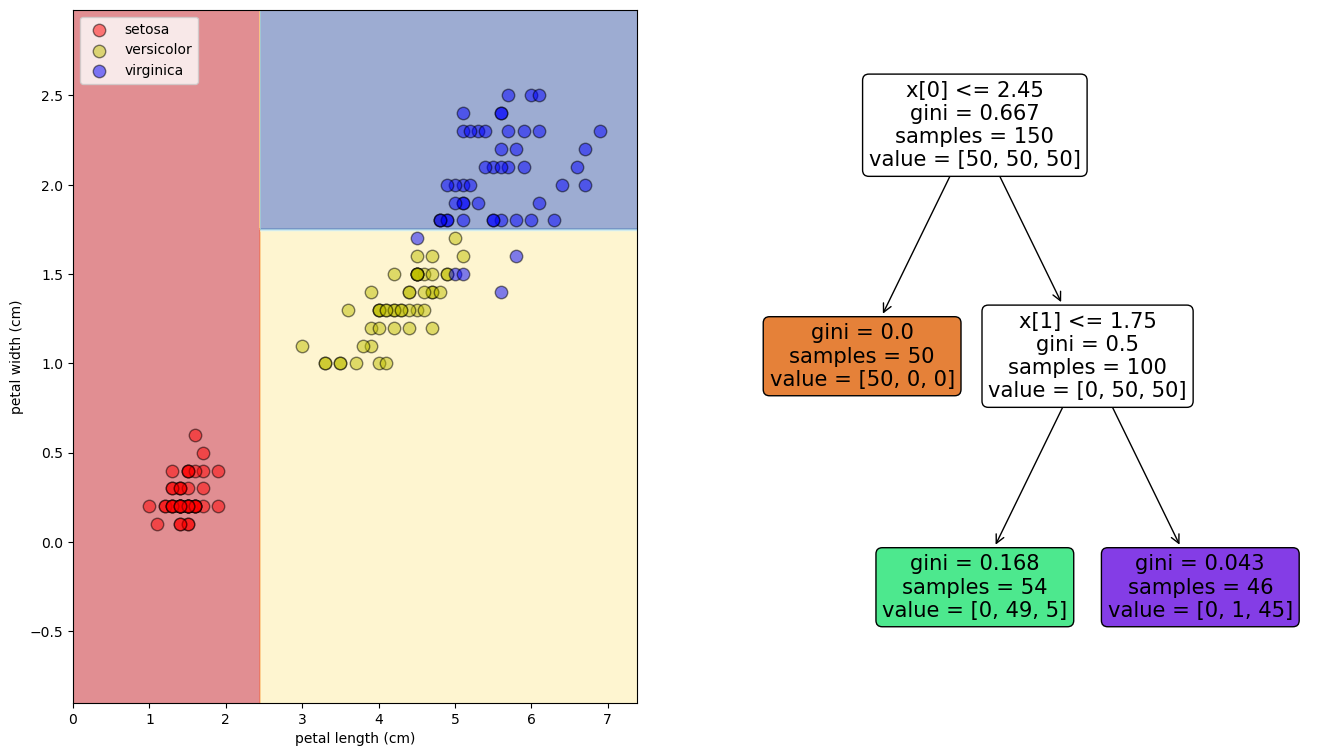

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

n_classes = 3
plot_colors = "ryb"

# plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = ax1.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.5)

ax1.set_xlabel(iris.feature_names[features[0]])
ax1.set_ylabel(iris.feature_names[features[1]])

# plot the training points
for i, color in zip(range(n_classes), plot_colors):
    if True : # Can test for a single class so points do not overlap
        idx = np.where(y == i)
        ax1.scatter(X[idx, 0], X[idx, 1], c=color, 
                    label=iris.target_names[i],
                    edgecolor='black', s=80, alpha=0.5)
ax1.legend(loc='upper left');

plot_tree(tree, ax=ax2, filled=True, rounded=True);

### Decision tree depth

Here, we will explore trees built using different values of the maximum depth parameter.  What phenomenon can we observe as we increase  maximum depth?  Also consider what you can say about the form of the decision boundary for decision trees.

Training Set Accuracy is: 0.97


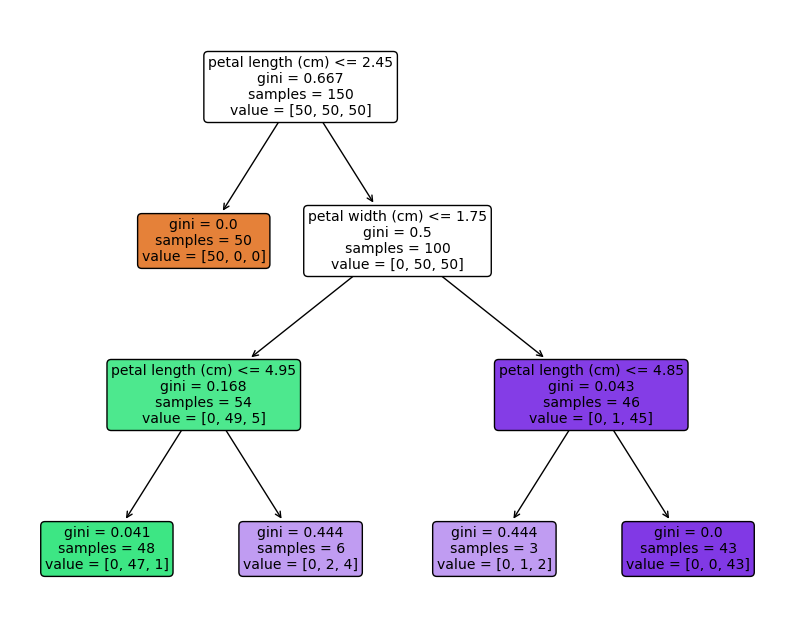

In [9]:
depth_bound = 3
features = [0,1,2,3]
X = iris.data[:, features]
y = iris.target
fnames = np.array([iris['feature_names'][i] for i in features])

tree = DecisionTreeClassifier(max_depth=depth_bound, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(10,8))
plot_tree(tree, filled=True, rounded=True, feature_names=fnames)
print(f'Training Set Accuracy is: {tree.score(X,y):2.2f}')

### The decision tree training algorithm

The decision tree training algorithm iteratively splits the data based on the value of a single feature.
At each step the algorithm picks the feature that leads to the greatest "purity" of the resulting split.  Purity in this context means that the splits are as homogeneous as possible in the composition of members of each class.  In decision trees, purity is typically measured using the [Gini impurity coefficient](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity).
Our description of the algorithm assumes binary features; continuous features are easy to consider as well.

**decision_tree_fit**($\mathcal{D}$, a labeled set of examples $(\mathbf{x}_i, y_i)$):

* if stopping criterion:  return
* pick best feature according to impurity criterion
* define $\mathcal{D}_0$ as the set of examples for which best feature = 0
* define $\mathcal{D}_1$ as the set of examples for which best feature = 1
* recursively generate two subtrees using $\mathcal{D}_0$ and $\mathcal{D}_1$

To fully specify the algorithm we need to decide on a stopping criterion, and a way of choosing good features for performing a split on.  Split criteria are based on the idea of looking for splits that decrease the "impurity" in a node in the decision tree, i.e. make it so that the examples are more homogeneous.  Examples of measures that are used to quantify impurity include the Gini impurity and  information gain.

When growing a decision tree you can stop when one of the following criteria is satisfied:

* if maximum depth has been reached
* if leaf node contain only examples of the same class
* if leaf node contains very few examples

Decision trees can be extended with the option for pruning the tree after it has been created to remove nodes deep in the tree in order to reduce overfitting.  They can also be extended to perform regression (cf. the CART decision tree algorithm).

#### Gini impurity

For completeness we provide the definition of the Gini impurity.
We assume a set of $C$ classes with frequencies $p_1, \ldots, p_C$.

$$
I_G(p) = \sum_{i=1}^C p_i (1 - p_i).
$$
For the case of two classes, it is 

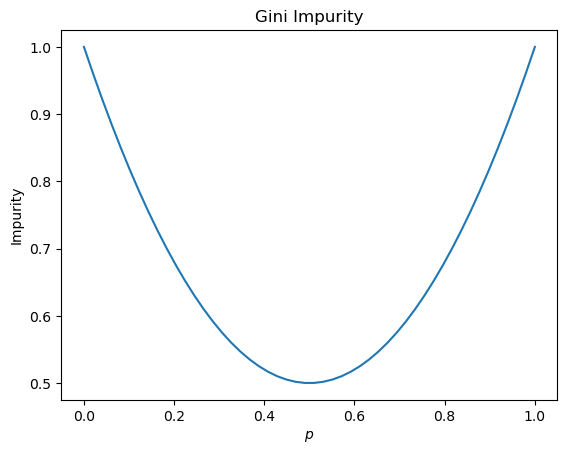

In [4]:
x = np.linspace(0,1,50)
y = (x*x) + (1-x)*(1-x) 
plt.plot(x,y)
plt.title('Gini Impurity')
plt.xlabel("$p$")
plt.ylabel("Impurity");

### Advantages and disadvantages of decision trees

#### Advantages

* Simple to understand and interpret, even for a non-expert.
* Whereas most machine learning techniques are "black boxes", decision trees are more of a "white box".
* Easily handle a mix of categorical and numerical data.
* Can handle missing data.
* Fast training.

#### Disadvantages

* Decision trees are unstable, meaning that a small change in the data can lead to a large change in the structure of the model.  This calls into question the interpretation of the model.
* They are often relatively inaccurate, especially for data that is high dimensional. There are other methods that perform better (e.g. SVMs).

Decision trees have been among the most popular classification algorithms because of their speed and versatility.  Their biggest drawback is their relatively low accuracy.
**Random forests** are a more recent development based on decision trees that provides a big improvement in accuracy while maintaining most of their advantages.

### References:

* **ID3**:
Quinlan, J. Ross. "Induction of decision trees." Machine learning 1.1 (1986): 81-106.

* **C4.5**:
Quinlan, J. Ross. C4. 5: programs for machine learning. Morgan Kaufmann Publishers, 1993.

* **CART**: Breiman, Leo *et al*. Classification and regression trees, 1984.
